In [ ]:
import pandas as pd
import scipy as sc
import numpy as np
import h5py
import matplotlib.pylab as plt
from tensorflow import keras
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_dataset = h5py.File("/content/drive/MyDrive/TEIA/docs/train_catvnoncat.h5", "r")
test_dataset = h5py.File("/content/drive/MyDrive/TEIA/docs/test_catvnoncat.h5", "r")

print(train_dataset.keys())

<KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>


(209, 64, 64, 3)
(50, 64, 64, 3)
(64, 64, 3)
(64, 64, 3)


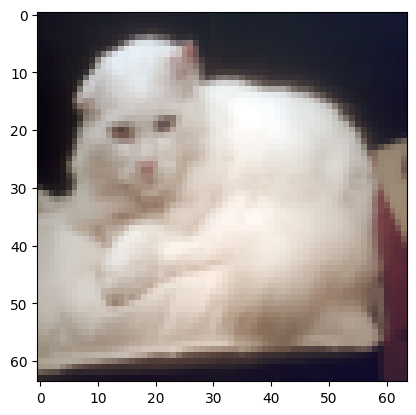

In [ ]:
xtrain_classes, xtrain, train_label =\
train_dataset["list_classes"],train_dataset["train_set_x"],train_dataset["train_set_y"]

test_classes, xtest,test_label =\
test_dataset["list_classes"],test_dataset["test_set_x"],test_dataset["test_set_y"]

print(np.shape(xtrain))
print(np.shape(xtest))
print(np.shape(xtrain[0]))
print(np.shape(xtest[0]))
plt.imshow(xtrain[13])

In [ ]:
xtrain_= np.reshape(xtrain,(209, 64*64*3))/255
xtest_ = np.reshape(xtest,(50, 64*64*3))/255
print(np.shape(xtrain_))
print(len(xtrain_[208]))
print(64*64*3)

(209, 12288)
12288
12288


1.

In [ ]:
Topology = [12288,3,4,6,1]
Activation = ["sigmoid","sigmoid","sigmoid","sigmoid","sigmoid","sigmoid"]

In [ ]:
class layer_nn():
  def __init__(self,act_fun,nlayer_presente,nlayer_before):
     np.random.seed(0)
     self.theta = 2*np.random.random((nlayer_presente, nlayer_before))-1
     self.B = 2*np.random.random((nlayer_presente, 1))-1
     self.act_fun = act_fun

  def output(self,Z,A):
    self.Z = Z
    self.A = A

  def derivative(self,dtheta,db):
    self.dtheta = dtheta
    self.db = db

def act_funcion(x, activation):
    if activation=="sigmoid":
     f = lambda x: 1/(1+np.exp(-x))
     return f(x)
    elif activation == "tanh":
     f = lambda x: np.tanh(x)
     return f(x)
    else :
     return 0

def act_deriv(x, activation):
    if activation=="sigmoid":
     f = lambda x: 1/(1+np.exp(-x))
     return f(x)*(1-f(x))

def build_nn(Topology,Activation):
  nn = []
  for i in range(1,len(Topology)):
    nn.append(layer_nn(Activation[i-1],Topology[i],Topology[i-1]))
  return nn


In [ ]:
nn = build_nn(Topology,Activation)
print(np.shape(nn[0].theta))
print(np.shape(nn[0].B))
print(nn[0].act_fun)

(3, 12288)
(3, 1)
sigmoid


In [ ]:
A0 = np.random.random(12288*209)
A0 = np.reshape(A0,(12288,209))

Z1 = nn[0].theta@A0 + nn[0].B
A1 = act_funcion(Z1,nn[0].act_fun)

print(np.shape(A0))
print(np.shape(Z1))
print(np.shape(A1))

#nn[0].output(Z1,A1)
#print(nn[00].A)

(12288, 209)
(3, 209)
(3, 209)


2.

In [ ]:
def forward_pass(A0,nn):
 update_nn = []
 update_A = []
 for layer in nn:
  li = layer
  Zi = li.theta@A0 + li.B
  Ai = act_funcion(Zi,li.act_fun)
  li.output(Zi,Ai)
  update_nn.append(li)
  update_A.append(Ai)
  A0 = np.copy(Ai)
 return update_A, update_nn

In [ ]:
A, nn = forward_pass(A0,nn)

3.

In [ ]:
def cost(A,Y):
  m = Y.shape[1]
  A = A[-1]
  #A = np.clip(A, 1e-12, 1 - 1e-12)
  J = -(1/m)*np.sum(Y*np.log(A)+(1-Y)*np.log(1-A))
  return J

In [ ]:
Y = np.array(train_label)
Y = np.reshape(Y,(1,209))
print(cost(A,Y))

0.795000575613929


4.

In [ ]:
A = A[-1]

In [ ]:
dAL = -(np.divide(Y,A) - np.divide(1 - Y,1 - A))
dZL = dAL*act_deriv(nn[-1].Z,nn[-1].act_fun)
dthetaL = (1/Y.shape[1])*dZL@nn[-2].A.T
dbL = (1/Y.shape[1])*np.sum(dZL,axis=1,keepdims=True)

nn[-1].derivative(dthetaL,dbL)

In [ ]:
def backwards(A0,nn,Y):
  m = Y.shape[1]
  update_nn = []

  A_L = nn[-1].A
  Z_L = nn[-1].Z

  dAL = -(np.divide(Y,A_L) - np.divide(1 - Y,1 - A_L))
  dZL = dAL*act_deriv(Z_L,nn[-1].act_fun)

  dthetaL = (1/m)*dZL@nn[-2].A.T
  dbL = (1/m)*np.sum(dZL,axis=1,keepdims=True)

  nn[-1].derivative(dthetaL,dbL)

  update_nn.append(nn[-1])

  for i in reversed(range(len(nn)-1)):
    if i > 0:
     dA = np.dot(nn[i+1].theta.T,dZL)
     dZ = dA*act_deriv(nn[i].Z,nn[i].act_fun)
     dtheta = (1/m)*dZ@nn[i-1].A.T
     db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
     nn[i].derivative(dtheta,db)
     update_nn.append(nn[i])
    if i == 0:
     dA = np.dot(nn[i+1].theta.T,dZL)
     dZ = dA*act_deriv(nn[i].Z,nn[i].act_fun)
     dtheta = (1/m)*dZ@A0.T
     db = (1/m)*np.sum(dZ,axis=1,keepdims=True)
     nn[i].derivative(dtheta,db)
     update_nn.append(nn[i])

    dZL = np.copy(dZ)

  return update_nn[::-1]

In [ ]:
nn = backwards(A0,nn,Y)

In [ ]:
def update_parameters(nn, learning_rate):
  updated_nn = []
  for layer in nn:
      layer.theta = layer.theta - learning_rate*layer.dtheta
      layer.B = layer.B - learning_rate*layer.db
      updated_nn.append(layer)
  return updated_nn

In [ ]:
nn = update_parameters(nn,0.01)
A, nn = forward_pass(A0,nn)
print(cost(A,Y))

0.7925825434703755


In [ ]:
for i in range(100):
  nn = backwards(A0,nn,Y)
  nn = update_parameters(nn,0.001)
  A, nn = forward_pass(A0,nn)
print(cost(A,Y))

0.7704720204017739


Comparacion con Keras

In [ ]:
digits = load_digits(n_class=6)
X, y = digits.data, digits.target
n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(866, 64)


In [ ]:
Topology = [64,16,6]
Activation = ["sigmoid","sigmoid"]

In [ ]:
def model():
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(Topology[1],input_dim = 64))
  model.add(keras.layers.Activation(Activation[0]))
  model.add(keras.layers.Dense(Topology[2]))
  model.add(keras.layers.Activation(Activation[1]))
  opt = keras.optimizers.SGD(learning_rate=0.01)
  model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=['accuracy'])
  return model

In [ ]:
keras.backend.clear_session()
model = model()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, verbose=1)

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1770 - loss: 1.8753 - val_accuracy: 0.2811 - val_loss: 1.6452
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2825 - loss: 1.6347 - val_accuracy: 0.4424 - val_loss: 1.5342
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4351 - loss: 1.5315 - val_accuracy: 0.5392 - val_loss: 1.4432
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5270 - loss: 1.4421 - val_accuracy: 0.6359 - val_loss: 1.3559
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6028 - loss: 1.3619 - val_accuracy: 0.6636 - val_loss: 1.2961
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6641 - loss: 1.3161 - val_accuracy: 0.7005 - val_loss: 1.2448
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7092 - loss: 1.2635 - val_accuracy: 0.7373 - val_loss: 1.2000
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7278 - loss: 1.2461 - val_accuracy: 0.7696 - val_loss

Train: 0.967, Test: 0.963


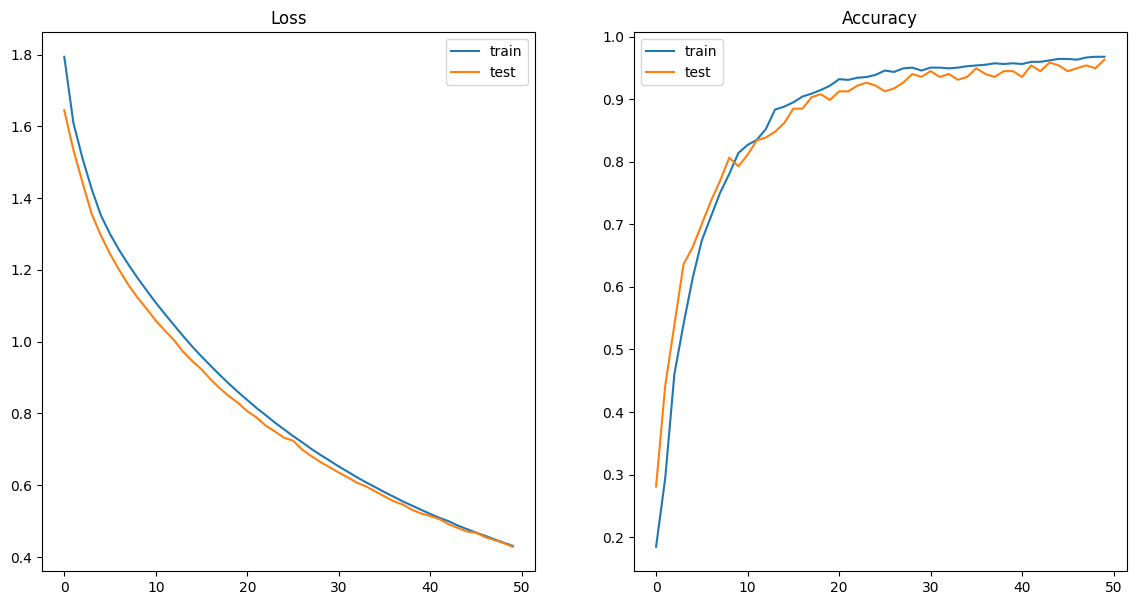

In [ ]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

plt.figure(figsize=(14,7))
plt.subplot(121)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.subplot(122)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

In [ ]:
nn = build_nn(Topology,Activation)
A0 = X_train.T
A, nn = forward_pass(A0,nn)

print(np.shape(nn[1].theta))
print(np.shape(nn[1].B))

(6, 16)
(6, 1)


In [ ]:
Y = np.array(y_train)
Y = np.reshape(Y,(1,866))
nn = backwards(A0,nn,Y)
nn = update_parameters(nn,0.001)
A, nn = forward_pass(A0,nn)
print(cost(A,Y))

15.550900780769247


In [ ]:
for i in range(50):
  nn = backwards(A0,nn,Y)
  nn = update_parameters(nn,0.001)
  A, nn = forward_pass(A0,nn)
print(cost(A,Y))

4.62456509033504
